# Problem 2: Generative Adversarial Networks

* **Learning Objective:** In this problem, you will implement a Generative Adversarial Network with the network structure proposed in [*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434), and learn a visualization technique, *activation maximization*.
* **Provided code:** The code for constructing the two parts of the GAN, the discriminator and the generator, is done for you, along with the skeleton code for the training.
* **TODOs:** You will need to figure out how to properly feed the data, compute the loss and update the parameters to complete the training and visualization. In addition, to test your understanding, you will answer some non-coding questions.

In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Introduction: The forger versus the police

*Note: read the story even if you are already familiar with GANs, as one of the questions is related to this story.*

Generative models try to model the distribution of the data in an explicit way, in the sense that we can easily sample new data points from this model. This is in contrast to discriminative models that try to infer the output from the input. In the class we have seen one classic deep generative model, the Variational Autoencoder (VAE). Here, we will learn another generative model that has risen to prominence in recent years, the Generative Adversarial Network (GAN).

As the maths of Generative Adversarial Networks is somewhat tedious, a story is often told of a forger and a police to illustrate the idea.

> Imagine a forger that makes fake bills, and a police that tries to find these forgeries. If the forger were a VAE, his goal would be to take some real bills, and try to replicate the real bills as precisely as possible. In GAN, he has a different idea in his mind: rather than trying to replicate the real bills, it suffices to make fake bills such that people *think* they are real.
> 
> Now let's start. In the beginning, the police knows nothing about how to distinguish between real and fake bills. The forger knows nothing either and only produces white paper.
> 
> In the first round, the police gets the fake bill and learns that the forgeries are white while the real bills are green. The forger then finds out that white papers can no longer fool the police and starts to produce green papers.
>
> In the second round, the police learns that real bills have denominations printed on them while the forgeries do not. The forger then finds out that plain papers can no longer fool the police and starts to print numbers on them.
>
> In the third round, the police learns that real bills have watermarks on them while the forgeries do not. The forger then has to reproduce the watermarks on his fake bills.
>
> ...
>
> Finally, the police is able to spot the tiniest difference between real and fake bills and the forger has to make perfect replicas of real bills to fool the police.

Now in a GAN, the forger becomes the generator and the police becomes the discriminator. The discriminator is a binary classifier with the two classes being "taken from the real data" ("real") and "generated by the generator" ("fake"). Its objective is to minimize the classification loss. The generator's objective is to generate samples so that the discriminator misclassifies them as real.

Here we have some complications: the goal is not to find one perfect fake sample. Such a sample will not actually fool the discriminator: if the forger makes hundreds of the exact same fake bill, they will all have the same serial number and the police will soon find out that they are fake. Instead, we want the generator to be able to generate a variety of fake samples such that when presented as a distribution alongside the distribution of real samples, these two are indistinguishable by the discriminator.

So how do we generate different samples with a diterministic generator? We provide it with random numbers as input.

Typically, for the discriminator we use binary cross entropy loss with label 1 being real and 0 being fake. For the generator, the input is a random vector drawn from a standard normal distribution. Denote the generator by $G_{\phi}(z)$, discriminator by $D_{\theta}(x)$, the distribution of the real samples by $p(x)$ and the input distribution to the generator by $q(z)$. Recall that the binary cross entropy loss with classifier output $y$ and label $\hat{y}$ is

$$L(y, \hat{y}) = -\hat{y} \log y - (1 - \hat{y}) \log (1 - y)$$

For the discriminator, the objective is

$$\min_{\theta} \mathrm{E}_{x \sim p(x)}[L(D_{\theta}(x), 1)] + \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

For the generator, the objective is

$$\max_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

The generator's objective corresponds to maximizing the classification loss of the discriminator on the generated samples. Alternatively, we can **minimize** the classification loss of the discriminator on the generated samples  **when labelled as real**:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

And this is what we will use in our implementation. The strength of the two networks should be balanced, so we train the two networks alternatingly, updating the parameters in both networks once in each interation.

## Problem 2-1: Implementing the GAN (30 pts)

We first load the data (CIFAR-10) and define some convenient functions. You should already have CIFAR-10 from assignment 1. Just copy the data from there or use ```data/get_datasets.sh``` if you don't have them.

In [2]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples = load_test_data() / 255.0

In [3]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.02, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

To save you some mundane work, we have defined a discriminator and a generator for you, in ```_discriminator()``` and ```_generator()``` respectively. Look at the code to see what layers are there.

For this part, you need to complete code blocks marked with "Prob 2-1":

*   **Build the computation graph for the losses:** Complete the following definitions in ```_init_ops()```
    *   ```fake_samples_op```: generate famples from ```noise```
    *   ```dis_loss_op```: compute discriminator's loss, with real samples from ```real_input``` and fake
        samples generated by the generator
    *   ```gen_loss_op```: compute generator's loss
*   **Define the optimizer:** We use RMSprop for training. Adam is observed to perform poorly with an unstable objective as is the case in GANs. We've defined ```dis_train_op``` and ```gen_train_op``` for you but those are wrong: rather than updating all the parameters all the time, when training one network we want to keep the other one fixed. Modify the definition to reflect this. [Check here](https://stackoverflow.com/a/35304001) if you are not sure how this is possible.
*   **Feed the data:** Feed the proper samples and labels in ```train()``` for training and in ```generate_one_sample()``` for visualizing the generated samples.

The batch normalization layers should operate in training mode. As per *[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)*, we put real samples and fake samples in different batches when training the discriminator.

*Note: use the advices on that page with caution if you are doing GAN for your team project. It is already more than 2 years old, which is a **really long time** in deep learning research. It does not reflect the latest results.*

In [16]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 25
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        self.fake_samples_op = self._generator(self.noise)
        self.dis_loss_op = (self._loss(self.fake_label, self._discriminator(self.fake_samples_op))+ self._loss(self.real_label, self._discriminator(self.real_input)))
        self.gen_loss_op = self._loss(self.real_label, self._discriminator(self.fake_samples_op))
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        dis_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dis')
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, 
                                                   var_list=dis_train_vars)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        gen_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'gen')
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list=gen_train_vars)
        
        ################################################################################
        # Prob 2-2: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        ################################################################################
        # Prob 2-2: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        tf.norm(self.actmax_sample_op - self.recon_sample)**2
        
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                dis_feed_dict = {self.real_input: batch_samples,
                                 self.real_label: ones,
                                 self.fake_label: zeros,
                                 self.noise: noise,
                                 self.is_train: True}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # gen_feed_dict = {}
                gen_feed_dict = {self.real_input: batch_samples,
                                 self.real_label: ones,
                                 self.fake_label: zeros,
                                 self.noise: noise,
                                 self.is_train: True}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-2: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        # actmax_init_val = None
        actmax_init_val = tf.convert_to_tensor(np.zeros((1, self.code_size)), dtype = tf.float32)
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-2: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-2     #
            ################################################################################   
            
            # recon_feed_dict = {}
            recon_feed_dict = {self.recon_sample:sample,self.is_train:False}
            
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        
        # gen_vis_feed_dict = {}
        gen_vis_feed_dict = {self.noise: code,self.is_train: False}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-2: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False}
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

Now let's do the training!

Don't panic if the loss curve goes wild. The two networks are competing for the loss curve to go different directions, so virtually anything can happen. If your code is correct, the generated samples should have a high variety.

Start training ...
Iteration 50/39050: dis loss = 0.8925, gen loss = 1.6221
Iteration 100/39050: dis loss = 0.8129, gen loss = 2.1583
Iteration 150/39050: dis loss = 1.3285, gen loss = 0.9585
Iteration 200/39050: dis loss = 1.3141, gen loss = 0.8852
Iteration 250/39050: dis loss = 1.3784, gen loss = 0.7711
Iteration 300/39050: dis loss = 1.4069, gen loss = 0.6616
Iteration 350/39050: dis loss = 1.3919, gen loss = 0.6412
Iteration 400/39050: dis loss = 1.3701, gen loss = 0.7215
Iteration 450/39050: dis loss = 1.3952, gen loss = 0.6845
Iteration 500/39050: dis loss = 1.3923, gen loss = 0.6726
Iteration 550/39050: dis loss = 1.3807, gen loss = 0.7011
Iteration 600/39050: dis loss = 1.4002, gen loss = 0.7188
Iteration 650/39050: dis loss = 1.4029, gen loss = 0.7162
Iteration 700/39050: dis loss = 1.3555, gen loss = 0.7426
Iteration 750/39050: dis loss = 1.3503, gen loss = 0.8354
Iteration 800/39050: dis loss = 1.4057, gen loss = 0.7189
Iteration 850/39050: dis loss = 1.3768, gen loss = 0.6

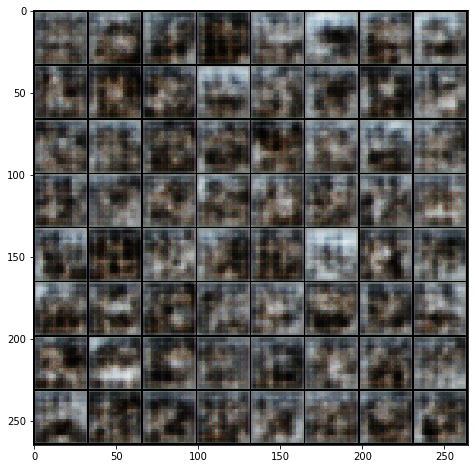

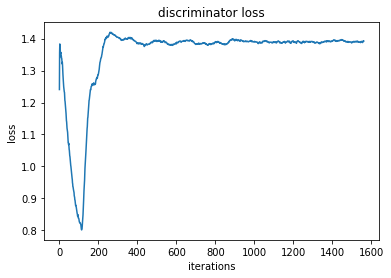

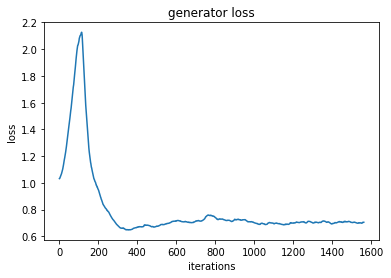

Iteration 1600/39050: dis loss = 1.4503, gen loss = 0.7040
Iteration 1650/39050: dis loss = 1.3967, gen loss = 0.6857
Iteration 1700/39050: dis loss = 1.4042, gen loss = 0.7479
Iteration 1750/39050: dis loss = 1.3407, gen loss = 0.7526
Iteration 1800/39050: dis loss = 1.3936, gen loss = 0.7018
Iteration 1850/39050: dis loss = 1.4073, gen loss = 0.7163
Iteration 1900/39050: dis loss = 1.3695, gen loss = 0.7026
Iteration 1950/39050: dis loss = 1.3425, gen loss = 0.7457
Iteration 2000/39050: dis loss = 1.4008, gen loss = 0.6606
Iteration 2050/39050: dis loss = 1.3196, gen loss = 0.7049
Iteration 2100/39050: dis loss = 1.3575, gen loss = 0.8007
Iteration 2150/39050: dis loss = 1.2900, gen loss = 0.8107
Iteration 2200/39050: dis loss = 1.3650, gen loss = 0.7741
Iteration 2250/39050: dis loss = 1.3807, gen loss = 0.7358
Iteration 2300/39050: dis loss = 1.3384, gen loss = 0.7234
Iteration 2350/39050: dis loss = 1.3289, gen loss = 0.7597
Iteration 2400/39050: dis loss = 1.4167, gen loss = 0.68

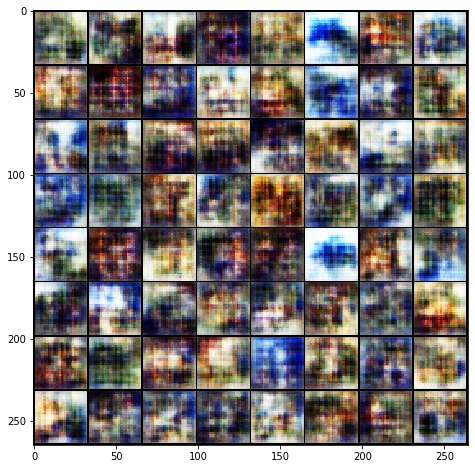

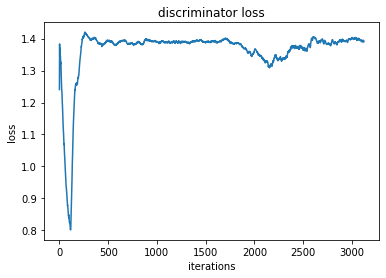

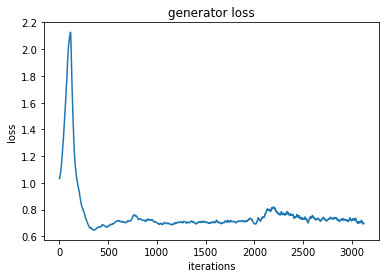

Iteration 3150/39050: dis loss = 1.4157, gen loss = 0.6759
Iteration 3200/39050: dis loss = 1.4087, gen loss = 0.6842
Iteration 3250/39050: dis loss = 1.4061, gen loss = 0.7700
Iteration 3300/39050: dis loss = 1.3665, gen loss = 0.8110
Iteration 3350/39050: dis loss = 1.4009, gen loss = 0.7428
Iteration 3400/39050: dis loss = 1.4025, gen loss = 0.7494
Iteration 3450/39050: dis loss = 1.4148, gen loss = 0.7221
Iteration 3500/39050: dis loss = 1.4245, gen loss = 0.6987
Iteration 3550/39050: dis loss = 1.3985, gen loss = 0.7098
Iteration 3600/39050: dis loss = 1.3932, gen loss = 0.7878
Iteration 3650/39050: dis loss = 1.3714, gen loss = 0.7192
Iteration 3700/39050: dis loss = 1.4157, gen loss = 0.6746
Iteration 3750/39050: dis loss = 1.4063, gen loss = 0.6349
Iteration 3800/39050: dis loss = 1.3520, gen loss = 0.7997
Iteration 3850/39050: dis loss = 1.3868, gen loss = 0.7053
Iteration 3900/39050: dis loss = 1.4019, gen loss = 0.7086
Iteration 3950/39050: dis loss = 1.3654, gen loss = 0.71

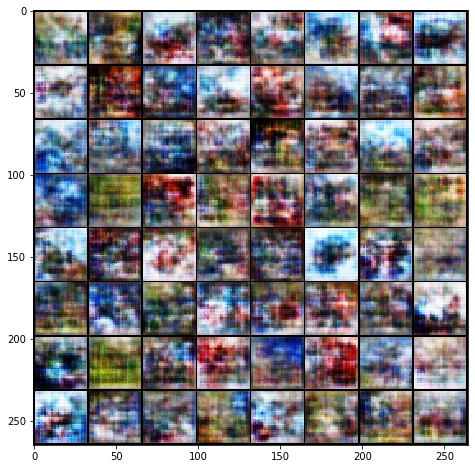

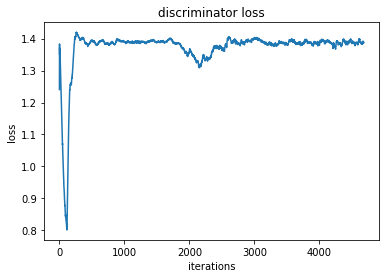

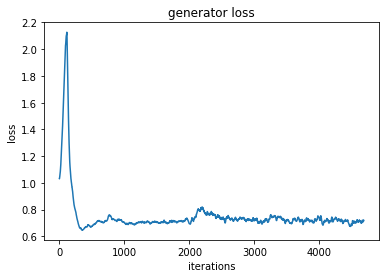

Iteration 4700/39050: dis loss = 1.3851, gen loss = 0.7163
Iteration 4750/39050: dis loss = 1.4048, gen loss = 0.6665
Iteration 4800/39050: dis loss = 1.3742, gen loss = 0.6889
Iteration 4850/39050: dis loss = 1.3660, gen loss = 0.6925
Iteration 4900/39050: dis loss = 1.3844, gen loss = 0.6834
Iteration 4950/39050: dis loss = 1.4088, gen loss = 0.7483
Iteration 5000/39050: dis loss = 1.3584, gen loss = 0.6793
Iteration 5050/39050: dis loss = 1.3951, gen loss = 0.6933
Iteration 5100/39050: dis loss = 1.3786, gen loss = 0.7368
Iteration 5150/39050: dis loss = 1.3785, gen loss = 0.6412
Iteration 5200/39050: dis loss = 1.4252, gen loss = 0.6872
Iteration 5250/39050: dis loss = 1.3711, gen loss = 0.7125
Iteration 5300/39050: dis loss = 1.4069, gen loss = 0.6762
Iteration 5350/39050: dis loss = 1.3804, gen loss = 0.7271
Iteration 5400/39050: dis loss = 1.3585, gen loss = 0.7443
Iteration 5450/39050: dis loss = 1.4220, gen loss = 0.6690
Iteration 5500/39050: dis loss = 1.3685, gen loss = 0.67

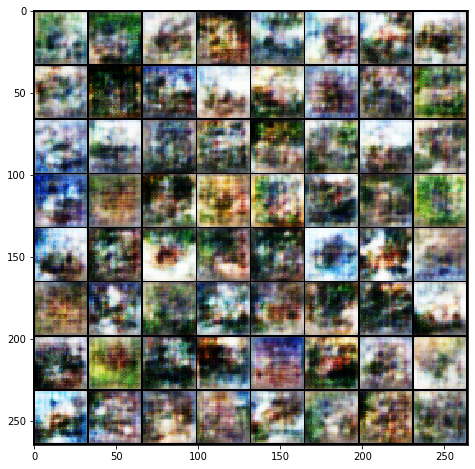

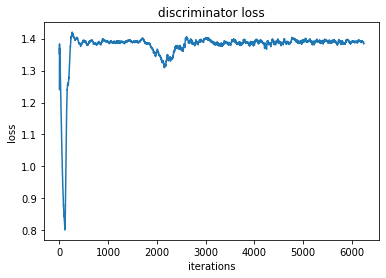

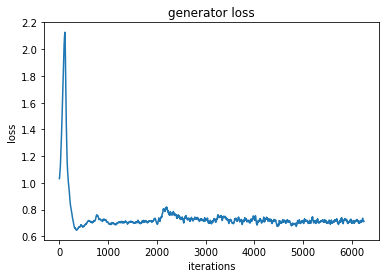

Iteration 6250/39050: dis loss = 1.4101, gen loss = 0.7667
Iteration 6300/39050: dis loss = 1.3753, gen loss = 0.7017
Iteration 6350/39050: dis loss = 1.4130, gen loss = 0.7584
Iteration 6400/39050: dis loss = 1.3668, gen loss = 0.7278
Iteration 6450/39050: dis loss = 1.4127, gen loss = 0.7626
Iteration 6500/39050: dis loss = 1.4160, gen loss = 0.7109
Iteration 6550/39050: dis loss = 1.3929, gen loss = 0.7116
Iteration 6600/39050: dis loss = 1.3985, gen loss = 0.7959
Iteration 6650/39050: dis loss = 1.3784, gen loss = 0.7797
Iteration 6700/39050: dis loss = 1.3710, gen loss = 0.7247
Iteration 6750/39050: dis loss = 1.3699, gen loss = 0.6827
Iteration 6800/39050: dis loss = 1.3634, gen loss = 0.6840
Iteration 6850/39050: dis loss = 1.4114, gen loss = 0.6709
Iteration 6900/39050: dis loss = 1.3965, gen loss = 0.6756
Iteration 6950/39050: dis loss = 1.4204, gen loss = 0.7242
Iteration 7000/39050: dis loss = 1.4093, gen loss = 0.6719
Iteration 7050/39050: dis loss = 1.3596, gen loss = 0.83

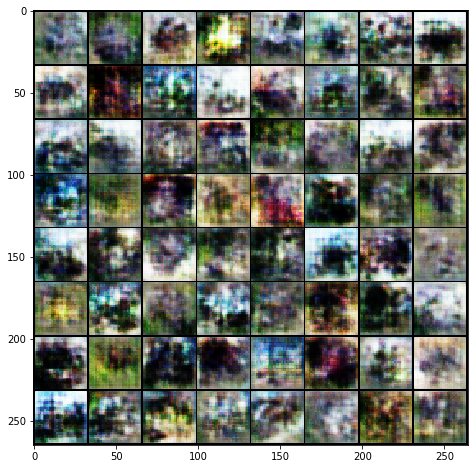

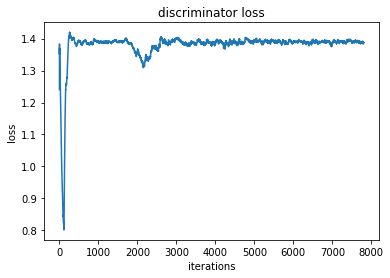

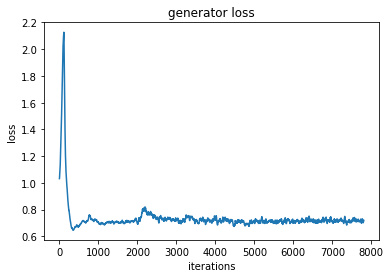

Iteration 7850/39050: dis loss = 1.3810, gen loss = 0.6958
Iteration 7900/39050: dis loss = 1.3994, gen loss = 0.7125
Iteration 7950/39050: dis loss = 1.3898, gen loss = 0.7507
Iteration 8000/39050: dis loss = 1.3690, gen loss = 0.7807
Iteration 8050/39050: dis loss = 1.3856, gen loss = 0.7113
Iteration 8100/39050: dis loss = 1.3788, gen loss = 0.7341
Iteration 8150/39050: dis loss = 1.4282, gen loss = 0.7064
Iteration 8200/39050: dis loss = 1.3958, gen loss = 0.7640
Iteration 8250/39050: dis loss = 1.4142, gen loss = 0.6691
Iteration 8300/39050: dis loss = 1.4074, gen loss = 0.7246
Iteration 8350/39050: dis loss = 1.3732, gen loss = 0.7706
Iteration 8400/39050: dis loss = 1.3530, gen loss = 0.7837
Iteration 8450/39050: dis loss = 1.4255, gen loss = 0.6556
Iteration 8500/39050: dis loss = 1.3263, gen loss = 0.8110
Iteration 8550/39050: dis loss = 1.4264, gen loss = 0.6805
Iteration 8600/39050: dis loss = 1.4023, gen loss = 0.7476
Iteration 8650/39050: dis loss = 1.4132, gen loss = 0.68

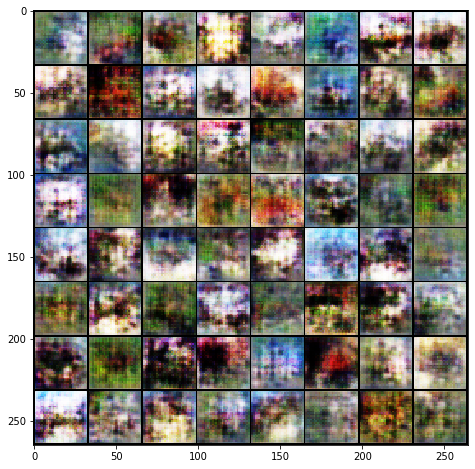

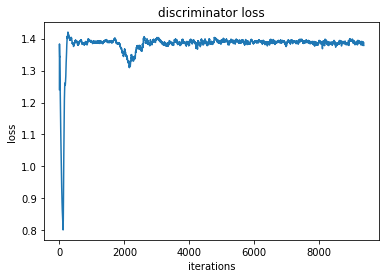

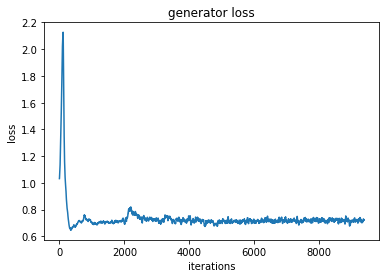

Iteration 9400/39050: dis loss = 1.3844, gen loss = 0.7160
Iteration 9450/39050: dis loss = 1.3981, gen loss = 0.7068
Iteration 9500/39050: dis loss = 1.4216, gen loss = 0.6968
Iteration 9550/39050: dis loss = 1.3547, gen loss = 0.6886
Iteration 9600/39050: dis loss = 1.4013, gen loss = 0.7003
Iteration 9650/39050: dis loss = 1.3848, gen loss = 0.7219
Iteration 9700/39050: dis loss = 1.3808, gen loss = 0.7134
Iteration 9750/39050: dis loss = 1.4011, gen loss = 0.7217
Iteration 9800/39050: dis loss = 1.4214, gen loss = 0.6749
Iteration 9850/39050: dis loss = 1.3906, gen loss = 0.6890
Iteration 9900/39050: dis loss = 1.3631, gen loss = 0.7854
Iteration 9950/39050: dis loss = 1.3746, gen loss = 0.7482
Iteration 10000/39050: dis loss = 1.4038, gen loss = 0.6844
Iteration 10050/39050: dis loss = 1.3915, gen loss = 0.7227
Iteration 10100/39050: dis loss = 1.3795, gen loss = 0.6363
Iteration 10150/39050: dis loss = 1.3677, gen loss = 0.6931
Iteration 10200/39050: dis loss = 1.3867, gen loss =

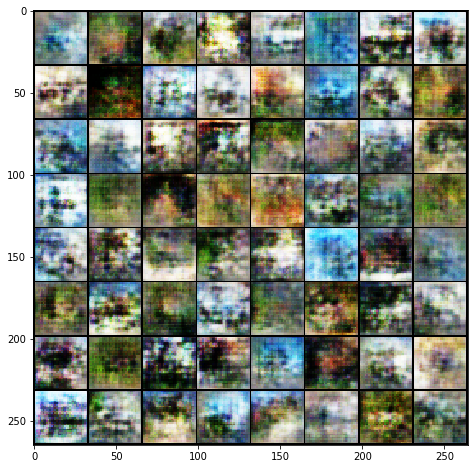

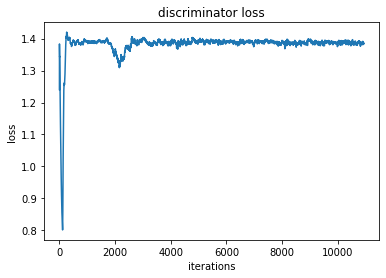

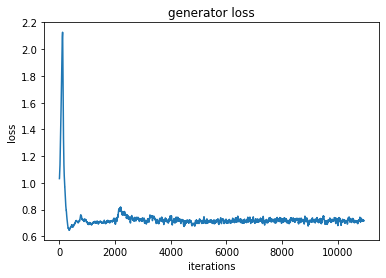

Iteration 10950/39050: dis loss = 1.3821, gen loss = 0.7080
Iteration 11000/39050: dis loss = 1.3942, gen loss = 0.7199
Iteration 11050/39050: dis loss = 1.3714, gen loss = 0.7270
Iteration 11100/39050: dis loss = 1.4276, gen loss = 0.7225
Iteration 11150/39050: dis loss = 1.3770, gen loss = 0.6968
Iteration 11200/39050: dis loss = 1.4120, gen loss = 0.7452
Iteration 11250/39050: dis loss = 1.3649, gen loss = 0.6952
Iteration 11300/39050: dis loss = 1.3990, gen loss = 0.7261
Iteration 11350/39050: dis loss = 1.3908, gen loss = 0.6688
Iteration 11400/39050: dis loss = 1.3661, gen loss = 0.6583
Iteration 11450/39050: dis loss = 1.3847, gen loss = 0.7192
Iteration 11500/39050: dis loss = 1.3793, gen loss = 0.6667
Iteration 11550/39050: dis loss = 1.3598, gen loss = 0.7627
Iteration 11600/39050: dis loss = 1.3972, gen loss = 0.7464
Iteration 11650/39050: dis loss = 1.3663, gen loss = 0.7420
Iteration 11700/39050: dis loss = 1.3855, gen loss = 0.6999
Iteration 11750/39050: dis loss = 1.3815

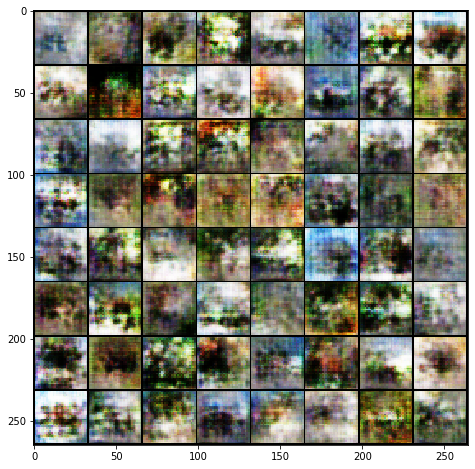

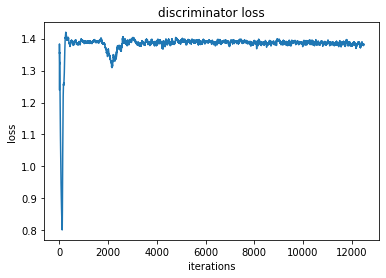

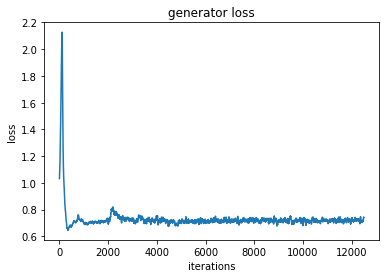

Iteration 12500/39050: dis loss = 1.3907, gen loss = 0.7419
Iteration 12550/39050: dis loss = 1.3975, gen loss = 0.7007
Iteration 12600/39050: dis loss = 1.3168, gen loss = 0.7961
Iteration 12650/39050: dis loss = 1.3488, gen loss = 0.8200
Iteration 12700/39050: dis loss = 1.3833, gen loss = 0.7516
Iteration 12750/39050: dis loss = 1.3528, gen loss = 0.6759
Iteration 12800/39050: dis loss = 1.3684, gen loss = 0.8085
Iteration 12850/39050: dis loss = 1.3982, gen loss = 0.7048
Iteration 12900/39050: dis loss = 1.3837, gen loss = 0.6965
Iteration 12950/39050: dis loss = 1.3927, gen loss = 0.7276
Iteration 13000/39050: dis loss = 1.4256, gen loss = 0.6892
Iteration 13050/39050: dis loss = 1.4215, gen loss = 0.7584
Iteration 13100/39050: dis loss = 1.3923, gen loss = 0.8024
Iteration 13150/39050: dis loss = 1.4101, gen loss = 0.7161
Iteration 13200/39050: dis loss = 1.3385, gen loss = 0.7036
Iteration 13250/39050: dis loss = 1.3873, gen loss = 0.7768
Iteration 13300/39050: dis loss = 1.3814

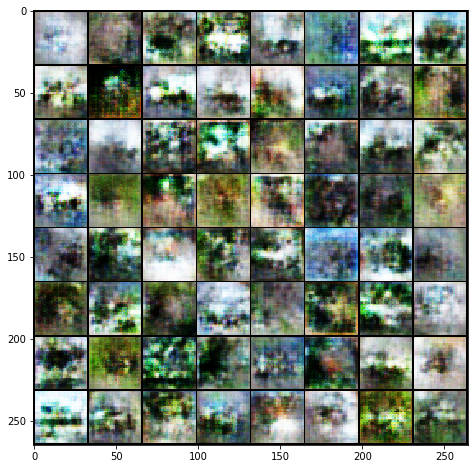

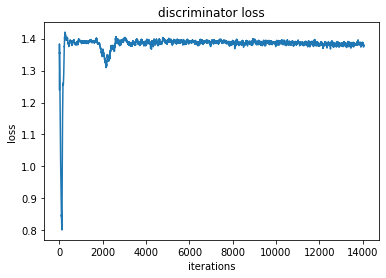

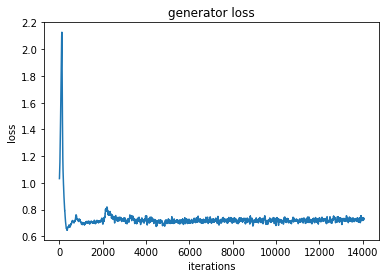

Iteration 14100/39050: dis loss = 1.3990, gen loss = 0.6757
Iteration 14150/39050: dis loss = 1.3836, gen loss = 0.7075
Iteration 14200/39050: dis loss = 1.3724, gen loss = 0.7211
Iteration 14250/39050: dis loss = 1.3804, gen loss = 0.7292
Iteration 14300/39050: dis loss = 1.3832, gen loss = 0.7345
Iteration 14350/39050: dis loss = 1.3726, gen loss = 0.7299
Iteration 14400/39050: dis loss = 1.3694, gen loss = 0.7857
Iteration 14450/39050: dis loss = 1.3712, gen loss = 0.7097
Iteration 14500/39050: dis loss = 1.4071, gen loss = 0.7346
Iteration 14550/39050: dis loss = 1.3850, gen loss = 0.7349
Iteration 14600/39050: dis loss = 1.3888, gen loss = 0.7303
Iteration 14650/39050: dis loss = 1.4339, gen loss = 0.6822
Iteration 14700/39050: dis loss = 1.3752, gen loss = 0.7164
Iteration 14750/39050: dis loss = 1.4561, gen loss = 0.6834
Iteration 14800/39050: dis loss = 1.3659, gen loss = 0.6769
Iteration 14850/39050: dis loss = 1.3870, gen loss = 0.7051
Iteration 14900/39050: dis loss = 1.3750

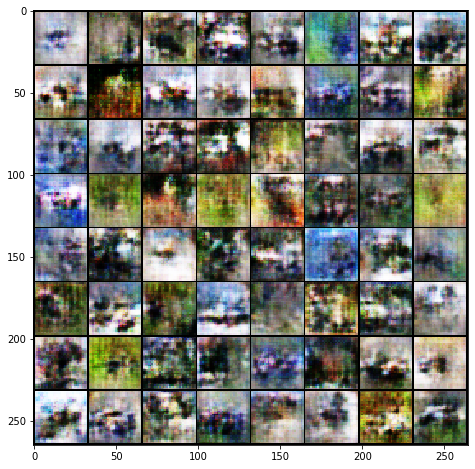

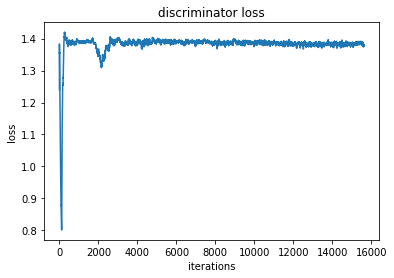

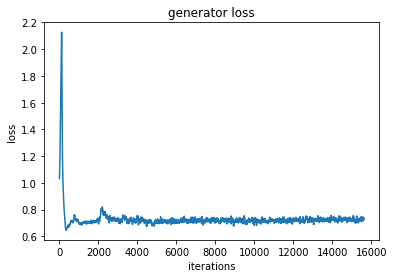

Iteration 15650/39050: dis loss = 1.3648, gen loss = 0.8370
Iteration 15700/39050: dis loss = 1.3798, gen loss = 0.7810
Iteration 15750/39050: dis loss = 1.3667, gen loss = 0.7440
Iteration 15800/39050: dis loss = 1.3918, gen loss = 0.6968
Iteration 15850/39050: dis loss = 1.4010, gen loss = 0.6867
Iteration 15900/39050: dis loss = 1.3536, gen loss = 0.7655
Iteration 15950/39050: dis loss = 1.4240, gen loss = 0.7353
Iteration 16000/39050: dis loss = 1.3784, gen loss = 0.7604
Iteration 16050/39050: dis loss = 1.4014, gen loss = 0.6424
Iteration 16100/39050: dis loss = 1.3994, gen loss = 0.7288
Iteration 16150/39050: dis loss = 1.3597, gen loss = 0.7895
Iteration 16200/39050: dis loss = 1.4188, gen loss = 0.7077
Iteration 16250/39050: dis loss = 1.4087, gen loss = 0.6837
Iteration 16300/39050: dis loss = 1.3857, gen loss = 0.7056
Iteration 16350/39050: dis loss = 1.3746, gen loss = 0.6818
Iteration 16400/39050: dis loss = 1.3898, gen loss = 0.7024
Iteration 16450/39050: dis loss = 1.3640

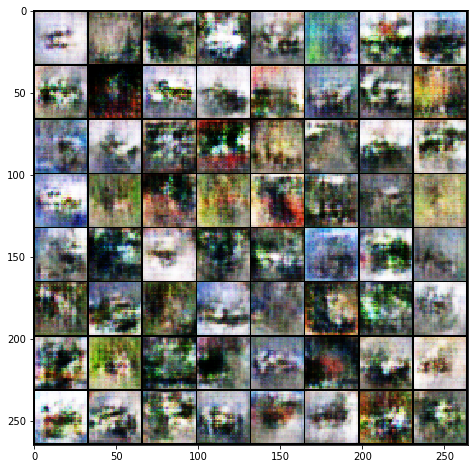

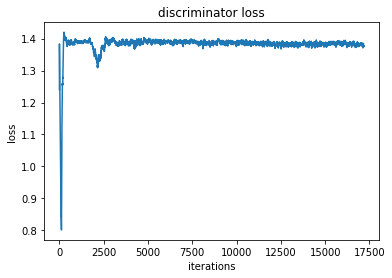

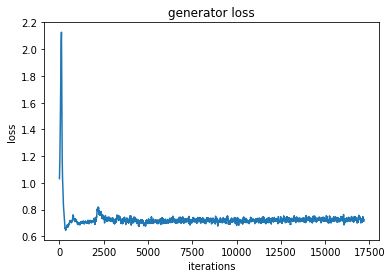

Iteration 17200/39050: dis loss = 1.3929, gen loss = 0.7116
Iteration 17250/39050: dis loss = 1.3791, gen loss = 0.6526
Iteration 17300/39050: dis loss = 1.3910, gen loss = 0.7899
Iteration 17350/39050: dis loss = 1.3421, gen loss = 0.7414
Iteration 17400/39050: dis loss = 1.3566, gen loss = 0.7599
Iteration 17450/39050: dis loss = 1.3717, gen loss = 0.7379
Iteration 17500/39050: dis loss = 1.3857, gen loss = 0.7901
Iteration 17550/39050: dis loss = 1.3661, gen loss = 0.6972
Iteration 17600/39050: dis loss = 1.3709, gen loss = 0.7787
Iteration 17650/39050: dis loss = 1.4005, gen loss = 0.7436
Iteration 17700/39050: dis loss = 1.4110, gen loss = 0.7542
Iteration 17750/39050: dis loss = 1.3596, gen loss = 0.7406
Iteration 17800/39050: dis loss = 1.3870, gen loss = 0.6968
Iteration 17850/39050: dis loss = 1.3714, gen loss = 0.7268
Iteration 17900/39050: dis loss = 1.3976, gen loss = 0.6880
Iteration 17950/39050: dis loss = 1.3773, gen loss = 0.7124
Iteration 18000/39050: dis loss = 1.3748

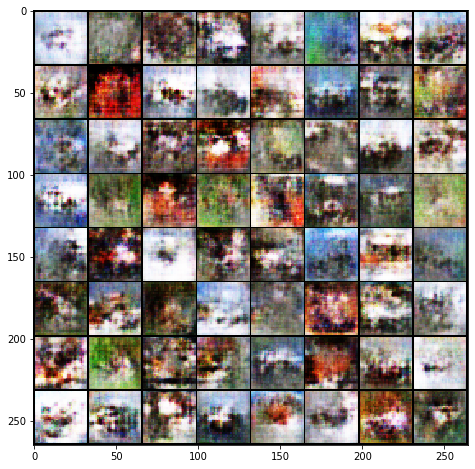

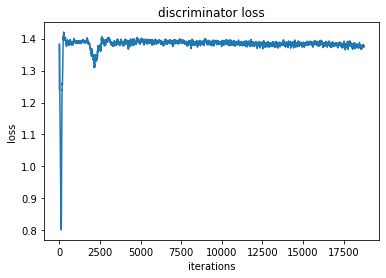

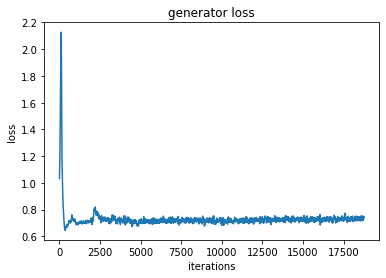

Iteration 18750/39050: dis loss = 1.3477, gen loss = 0.8018
Iteration 18800/39050: dis loss = 1.3844, gen loss = 0.7195
Iteration 18850/39050: dis loss = 1.3658, gen loss = 0.7866
Iteration 18900/39050: dis loss = 1.3789, gen loss = 0.7025
Iteration 18950/39050: dis loss = 1.3585, gen loss = 0.7510
Iteration 19000/39050: dis loss = 1.3883, gen loss = 0.8273
Iteration 19050/39050: dis loss = 1.3762, gen loss = 0.7717
Iteration 19100/39050: dis loss = 1.3632, gen loss = 0.7075
Iteration 19150/39050: dis loss = 1.3540, gen loss = 0.7575
Iteration 19200/39050: dis loss = 1.3480, gen loss = 0.7569
Iteration 19250/39050: dis loss = 1.3275, gen loss = 0.7911
Iteration 19300/39050: dis loss = 1.3704, gen loss = 0.7472
Iteration 19350/39050: dis loss = 1.3963, gen loss = 0.7061
Iteration 19400/39050: dis loss = 1.3646, gen loss = 0.7462
Iteration 19450/39050: dis loss = 1.3356, gen loss = 0.6538
Iteration 19500/39050: dis loss = 1.3981, gen loss = 0.7468
Iteration 19550/39050: dis loss = 1.3903

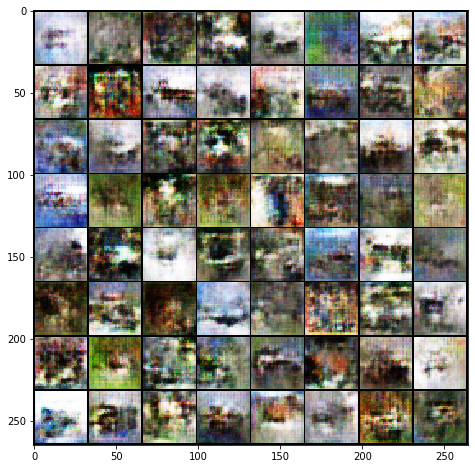

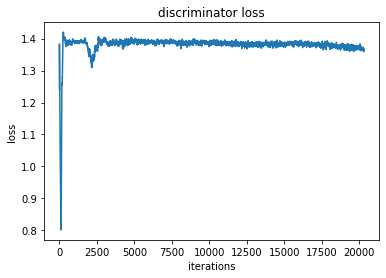

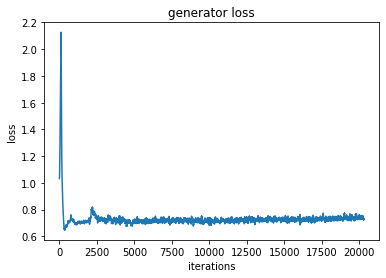

Iteration 20350/39050: dis loss = 1.3379, gen loss = 0.8859
Iteration 20400/39050: dis loss = 1.4062, gen loss = 0.7415
Iteration 20450/39050: dis loss = 1.3602, gen loss = 0.7568
Iteration 20500/39050: dis loss = 1.3911, gen loss = 0.6813
Iteration 20550/39050: dis loss = 1.3367, gen loss = 0.6682
Iteration 20600/39050: dis loss = 1.3977, gen loss = 0.7376
Iteration 20650/39050: dis loss = 1.3746, gen loss = 0.7828
Iteration 20700/39050: dis loss = 1.3531, gen loss = 0.6950
Iteration 20750/39050: dis loss = 1.3483, gen loss = 0.7578
Iteration 20800/39050: dis loss = 1.4065, gen loss = 0.7137
Iteration 20850/39050: dis loss = 1.3688, gen loss = 0.6674
Iteration 20900/39050: dis loss = 1.3795, gen loss = 0.7371
Iteration 20950/39050: dis loss = 1.3995, gen loss = 0.8234
Iteration 21000/39050: dis loss = 1.3197, gen loss = 0.9013
Iteration 21050/39050: dis loss = 1.4813, gen loss = 0.7318
Iteration 21100/39050: dis loss = 1.3894, gen loss = 0.7105
Iteration 21150/39050: dis loss = 1.3419

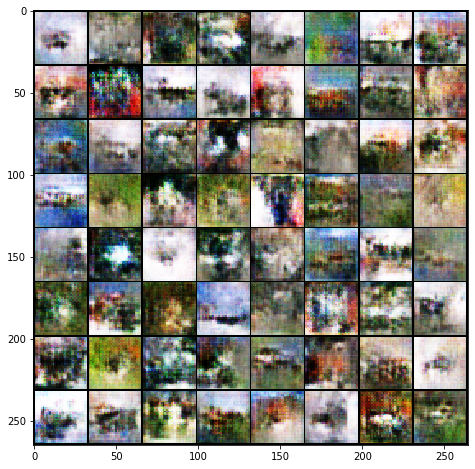

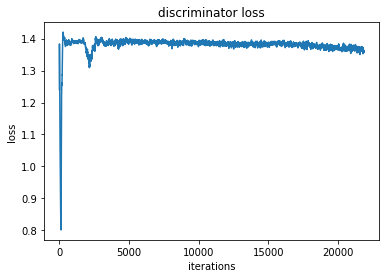

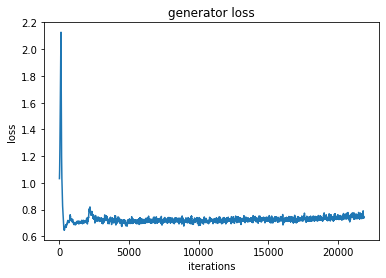

Iteration 21900/39050: dis loss = 1.3366, gen loss = 0.7969
Iteration 21950/39050: dis loss = 1.3699, gen loss = 0.7285
Iteration 22000/39050: dis loss = 1.3626, gen loss = 0.7419
Iteration 22050/39050: dis loss = 1.3475, gen loss = 0.7064
Iteration 22100/39050: dis loss = 1.3664, gen loss = 0.7379
Iteration 22150/39050: dis loss = 1.3753, gen loss = 0.7218
Iteration 22200/39050: dis loss = 1.4025, gen loss = 0.6634
Iteration 22250/39050: dis loss = 1.3508, gen loss = 0.8238
Iteration 22300/39050: dis loss = 1.3311, gen loss = 0.7730
Iteration 22350/39050: dis loss = 1.4058, gen loss = 0.7316
Iteration 22400/39050: dis loss = 1.3862, gen loss = 0.6838
Iteration 22450/39050: dis loss = 1.3877, gen loss = 0.8121
Iteration 22500/39050: dis loss = 1.4156, gen loss = 0.6754
Iteration 22550/39050: dis loss = 1.3317, gen loss = 0.8048
Iteration 22600/39050: dis loss = 1.3529, gen loss = 0.8291
Iteration 22650/39050: dis loss = 1.3173, gen loss = 0.7171
Iteration 22700/39050: dis loss = 1.3613

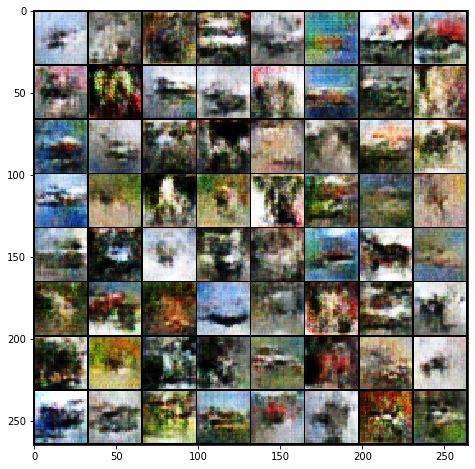

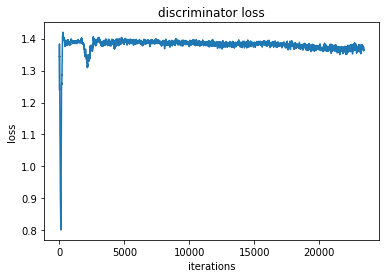

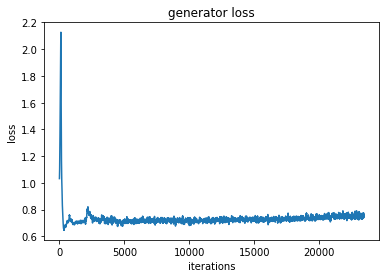

Iteration 23450/39050: dis loss = 1.3842, gen loss = 0.6963
Iteration 23500/39050: dis loss = 1.3710, gen loss = 0.8879
Iteration 23550/39050: dis loss = 1.3326, gen loss = 0.8180
Iteration 23600/39050: dis loss = 1.3254, gen loss = 0.8280
Iteration 23650/39050: dis loss = 1.4067, gen loss = 0.6617
Iteration 23700/39050: dis loss = 1.4504, gen loss = 0.6982
Iteration 23750/39050: dis loss = 1.3427, gen loss = 0.7452
Iteration 23800/39050: dis loss = 1.3207, gen loss = 0.7425
Iteration 23850/39050: dis loss = 1.4181, gen loss = 0.7709
Iteration 23900/39050: dis loss = 1.3654, gen loss = 0.7836
Iteration 23950/39050: dis loss = 1.3809, gen loss = 0.6946
Iteration 24000/39050: dis loss = 1.2981, gen loss = 0.7590
Iteration 24050/39050: dis loss = 1.3205, gen loss = 0.6747
Iteration 24100/39050: dis loss = 1.3617, gen loss = 0.7374
Iteration 24150/39050: dis loss = 1.3985, gen loss = 0.7059
Iteration 24200/39050: dis loss = 1.3439, gen loss = 0.7250
Iteration 24250/39050: dis loss = 1.3462

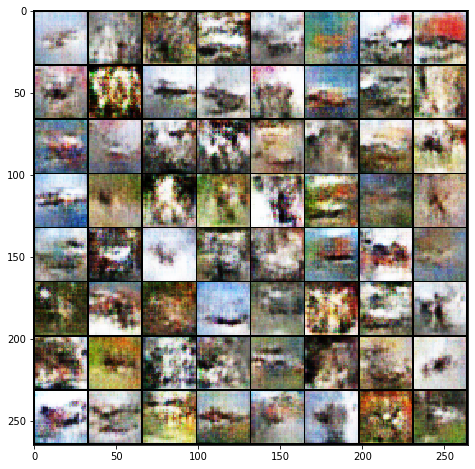

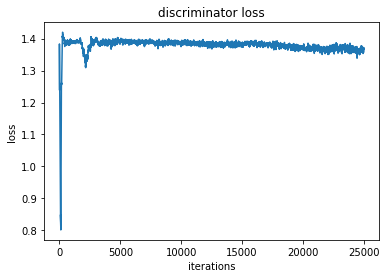

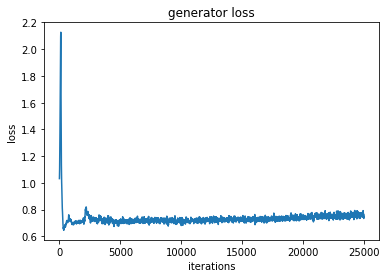

Iteration 25000/39050: dis loss = 1.3512, gen loss = 0.7555
Iteration 25050/39050: dis loss = 1.3984, gen loss = 0.6909
Iteration 25100/39050: dis loss = 1.3193, gen loss = 0.8143
Iteration 25150/39050: dis loss = 1.2893, gen loss = 0.8444
Iteration 25200/39050: dis loss = 1.3988, gen loss = 0.6418
Iteration 25250/39050: dis loss = 1.3662, gen loss = 0.7715
Iteration 25300/39050: dis loss = 1.3355, gen loss = 0.8870
Iteration 25350/39050: dis loss = 1.2943, gen loss = 0.7712
Iteration 25400/39050: dis loss = 1.3043, gen loss = 0.9582
Iteration 25450/39050: dis loss = 1.3654, gen loss = 0.7078
Iteration 25500/39050: dis loss = 1.3100, gen loss = 0.6714
Iteration 25550/39050: dis loss = 1.2718, gen loss = 0.9356
Iteration 25600/39050: dis loss = 1.4303, gen loss = 0.7971
Iteration 25650/39050: dis loss = 1.3613, gen loss = 0.7595
Iteration 25700/39050: dis loss = 1.3503, gen loss = 0.7079
Iteration 25750/39050: dis loss = 1.3605, gen loss = 0.9224
Iteration 25800/39050: dis loss = 1.3335

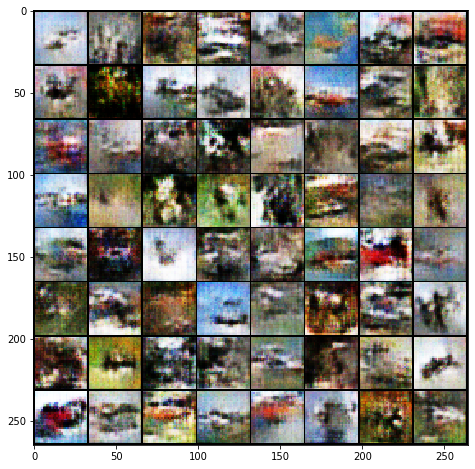

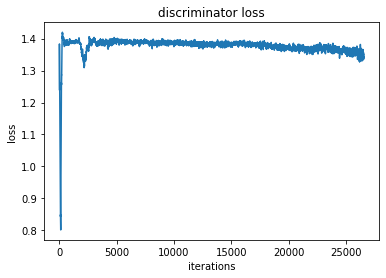

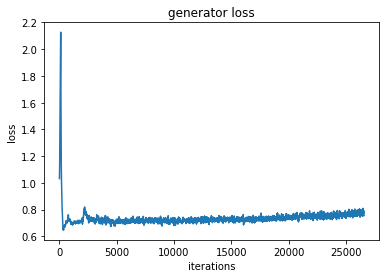

Iteration 26600/39050: dis loss = 1.3913, gen loss = 0.6848
Iteration 26650/39050: dis loss = 1.4150, gen loss = 0.6487
Iteration 26700/39050: dis loss = 1.3605, gen loss = 0.7548
Iteration 26750/39050: dis loss = 1.3015, gen loss = 0.9172
Iteration 26800/39050: dis loss = 1.3324, gen loss = 0.9384
Iteration 26850/39050: dis loss = 1.4793, gen loss = 0.6613
Iteration 26900/39050: dis loss = 1.2841, gen loss = 0.7766
Iteration 26950/39050: dis loss = 1.3206, gen loss = 0.8151
Iteration 27000/39050: dis loss = 1.3386, gen loss = 0.7226
Iteration 27050/39050: dis loss = 1.3580, gen loss = 0.6838
Iteration 27100/39050: dis loss = 1.3064, gen loss = 0.8294
Iteration 27150/39050: dis loss = 1.3358, gen loss = 0.6507
Iteration 27200/39050: dis loss = 1.3734, gen loss = 0.7331
Iteration 27250/39050: dis loss = 1.3473, gen loss = 0.7733
Iteration 27300/39050: dis loss = 1.3526, gen loss = 0.6904
Iteration 27350/39050: dis loss = 1.2843, gen loss = 0.6964
Iteration 27400/39050: dis loss = 1.3749

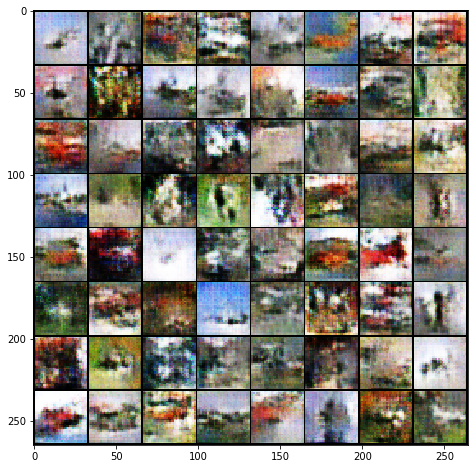

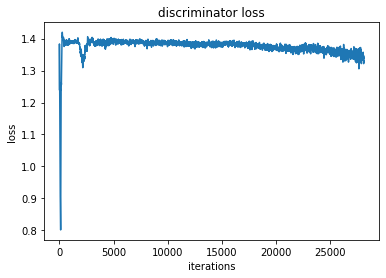

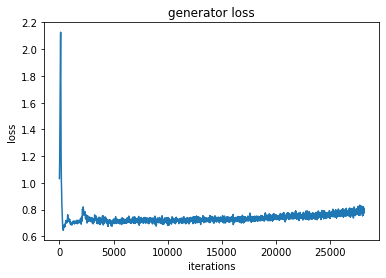

Iteration 28150/39050: dis loss = 1.3142, gen loss = 1.0065
Iteration 28200/39050: dis loss = 1.2868, gen loss = 0.8186
Iteration 28250/39050: dis loss = 1.3688, gen loss = 0.7834
Iteration 28300/39050: dis loss = 1.2901, gen loss = 1.0907
Iteration 28350/39050: dis loss = 1.4097, gen loss = 0.9583
Iteration 28400/39050: dis loss = 1.2293, gen loss = 0.8545
Iteration 28450/39050: dis loss = 1.3437, gen loss = 0.7244
Iteration 28500/39050: dis loss = 1.2949, gen loss = 0.8123
Iteration 28550/39050: dis loss = 1.3574, gen loss = 0.6274
Iteration 28600/39050: dis loss = 1.4797, gen loss = 0.7183
Iteration 28650/39050: dis loss = 1.2907, gen loss = 0.7056
Iteration 28700/39050: dis loss = 1.3092, gen loss = 0.8235
Iteration 28750/39050: dis loss = 1.3418, gen loss = 0.9559
Iteration 28800/39050: dis loss = 1.4606, gen loss = 0.6029
Iteration 28850/39050: dis loss = 1.3133, gen loss = 1.1032
Iteration 28900/39050: dis loss = 1.1681, gen loss = 0.9469
Iteration 28950/39050: dis loss = 1.3581

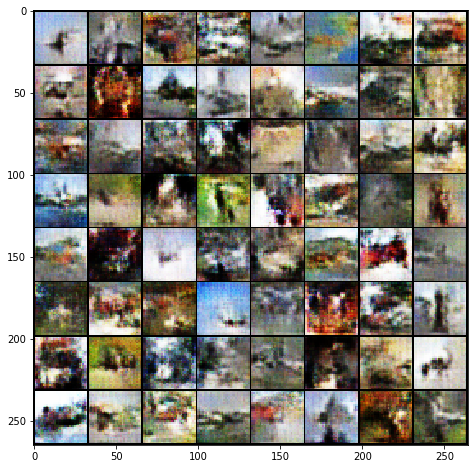

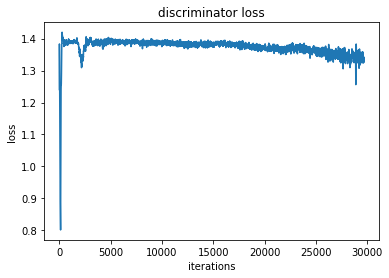

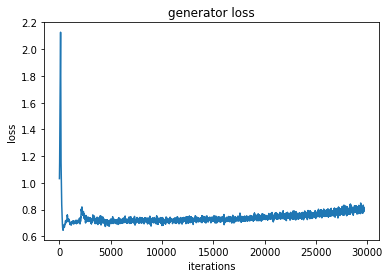

Iteration 29700/39050: dis loss = 1.3199, gen loss = 0.7172
Iteration 29750/39050: dis loss = 1.2752, gen loss = 0.7515
Iteration 29800/39050: dis loss = 1.3220, gen loss = 0.7750
Iteration 29850/39050: dis loss = 1.3224, gen loss = 0.8163
Iteration 29900/39050: dis loss = 1.2895, gen loss = 0.7625
Iteration 29950/39050: dis loss = 1.3385, gen loss = 0.8030
Iteration 30000/39050: dis loss = 1.3458, gen loss = 0.7067
Iteration 30050/39050: dis loss = 1.4164, gen loss = 0.5914
Iteration 30100/39050: dis loss = 1.1982, gen loss = 1.1604
Iteration 30150/39050: dis loss = 1.3239, gen loss = 0.7873
Iteration 30200/39050: dis loss = 1.3642, gen loss = 0.8106
Iteration 30250/39050: dis loss = 1.2715, gen loss = 0.7303
Iteration 30300/39050: dis loss = 1.3793, gen loss = 0.6486
Iteration 30350/39050: dis loss = 1.3874, gen loss = 0.7136
Iteration 30400/39050: dis loss = 1.3819, gen loss = 0.7455
Iteration 30450/39050: dis loss = 1.3093, gen loss = 0.8631
Iteration 30500/39050: dis loss = 1.3946

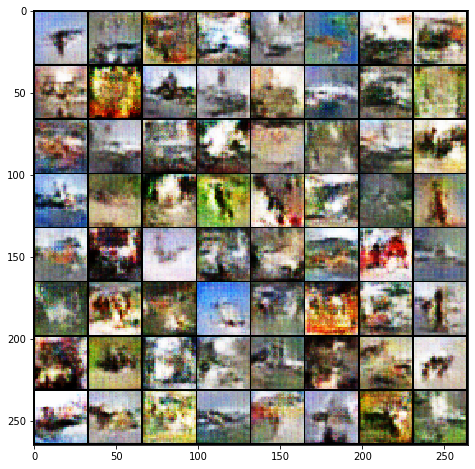

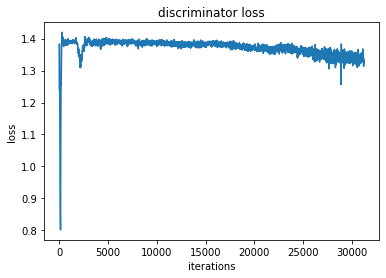

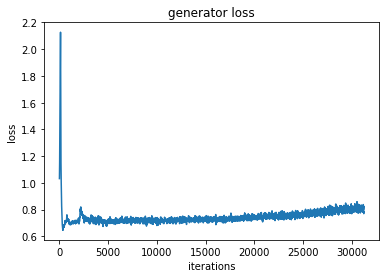

Iteration 31250/39050: dis loss = 1.2850, gen loss = 0.6915
Iteration 31300/39050: dis loss = 1.3331, gen loss = 0.7296
Iteration 31350/39050: dis loss = 1.4607, gen loss = 0.6273
Iteration 31400/39050: dis loss = 1.2551, gen loss = 0.8553
Iteration 31450/39050: dis loss = 1.3738, gen loss = 0.7683
Iteration 31500/39050: dis loss = 1.3545, gen loss = 0.8610
Iteration 31550/39050: dis loss = 1.3623, gen loss = 0.8149
Iteration 31600/39050: dis loss = 1.3331, gen loss = 0.6656
Iteration 31650/39050: dis loss = 1.4029, gen loss = 1.0050
Iteration 31700/39050: dis loss = 1.2869, gen loss = 0.7420
Iteration 31750/39050: dis loss = 1.4167, gen loss = 0.7624
Iteration 31800/39050: dis loss = 1.3526, gen loss = 0.7657
Iteration 31850/39050: dis loss = 1.3889, gen loss = 0.9355
Iteration 31900/39050: dis loss = 1.3024, gen loss = 0.8219
Iteration 31950/39050: dis loss = 1.2915, gen loss = 0.6918
Iteration 32000/39050: dis loss = 1.4188, gen loss = 0.9514
Iteration 32050/39050: dis loss = 1.3249

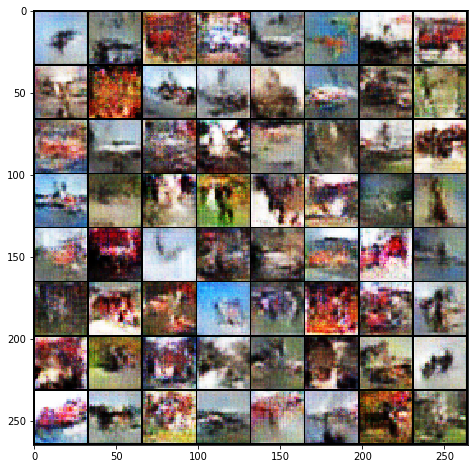

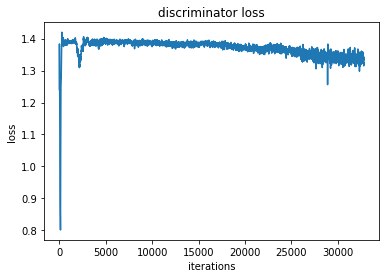

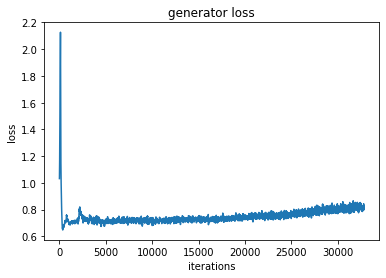

Iteration 32850/39050: dis loss = 1.3012, gen loss = 0.8464
Iteration 32900/39050: dis loss = 1.3398, gen loss = 0.7441
Iteration 32950/39050: dis loss = 1.2214, gen loss = 0.9427
Iteration 33000/39050: dis loss = 1.2932, gen loss = 0.9205
Iteration 33050/39050: dis loss = 1.3776, gen loss = 0.6720
Iteration 33100/39050: dis loss = 1.4030, gen loss = 0.6087
Iteration 33150/39050: dis loss = 1.3125, gen loss = 0.9979
Iteration 33200/39050: dis loss = 1.3818, gen loss = 0.9530
Iteration 33250/39050: dis loss = 1.2966, gen loss = 0.8300
Iteration 33300/39050: dis loss = 1.3566, gen loss = 0.8927
Iteration 33350/39050: dis loss = 1.3631, gen loss = 0.8646
Iteration 33400/39050: dis loss = 1.3675, gen loss = 0.9683
Iteration 33450/39050: dis loss = 1.3014, gen loss = 0.7869
Iteration 33500/39050: dis loss = 1.4984, gen loss = 0.5725
Iteration 33550/39050: dis loss = 1.2569, gen loss = 0.7712
Iteration 33600/39050: dis loss = 1.2935, gen loss = 0.8247
Iteration 33650/39050: dis loss = 1.3985

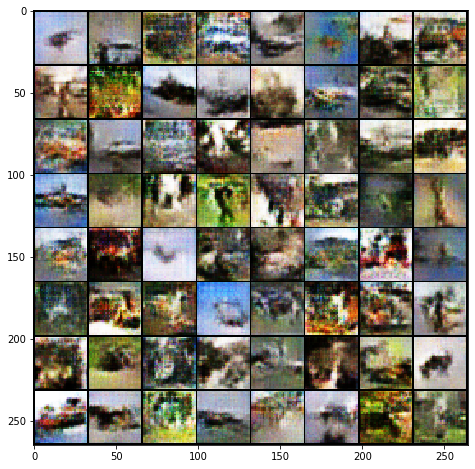

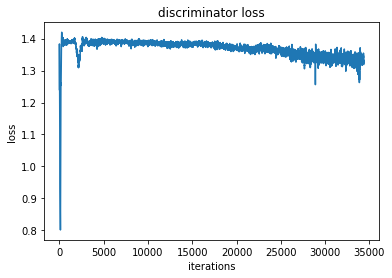

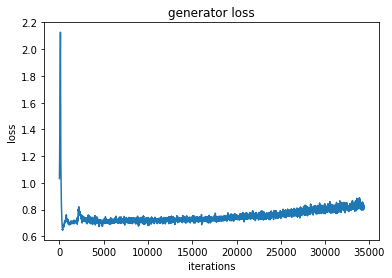

Iteration 34400/39050: dis loss = 1.3389, gen loss = 0.8656
Iteration 34450/39050: dis loss = 1.3435, gen loss = 0.7832
Iteration 34500/39050: dis loss = 1.3032, gen loss = 0.9274
Iteration 34550/39050: dis loss = 1.4545, gen loss = 0.9539
Iteration 34600/39050: dis loss = 1.2421, gen loss = 0.9409
Iteration 34650/39050: dis loss = 1.3375, gen loss = 0.8655
Iteration 34700/39050: dis loss = 1.3524, gen loss = 0.8375
Iteration 34750/39050: dis loss = 1.3983, gen loss = 0.7409
Iteration 34800/39050: dis loss = 1.2481, gen loss = 0.8700
Iteration 34850/39050: dis loss = 1.2846, gen loss = 0.9470
Iteration 34900/39050: dis loss = 1.3347, gen loss = 0.8172
Iteration 34950/39050: dis loss = 1.2772, gen loss = 0.9185
Iteration 35000/39050: dis loss = 1.2734, gen loss = 1.1703
Iteration 35050/39050: dis loss = 1.4270, gen loss = 0.7304
Iteration 35100/39050: dis loss = 1.3607, gen loss = 0.9092
Iteration 35150/39050: dis loss = 1.3448, gen loss = 0.7372
Iteration 35200/39050: dis loss = 1.2889

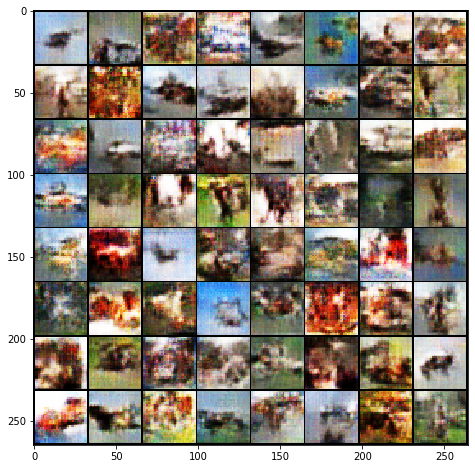

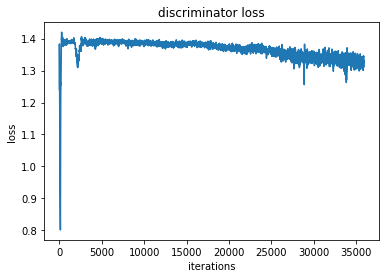

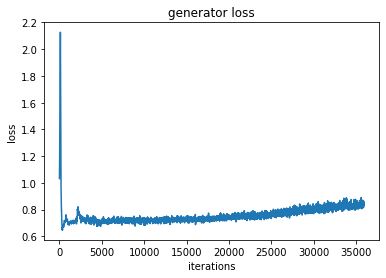

Iteration 35950/39050: dis loss = 1.3772, gen loss = 0.8991
Iteration 36000/39050: dis loss = 1.2963, gen loss = 0.8262
Iteration 36050/39050: dis loss = 1.2214, gen loss = 0.9870
Iteration 36100/39050: dis loss = 1.3716, gen loss = 0.9405
Iteration 36150/39050: dis loss = 1.3438, gen loss = 0.9307
Iteration 36200/39050: dis loss = 1.3379, gen loss = 0.9271
Iteration 36250/39050: dis loss = 1.3756, gen loss = 0.8737
Iteration 36300/39050: dis loss = 1.4337, gen loss = 1.0030
Iteration 36350/39050: dis loss = 1.1868, gen loss = 0.9586
Iteration 36400/39050: dis loss = 1.2781, gen loss = 0.8693
Iteration 36450/39050: dis loss = 1.2321, gen loss = 0.8407
Iteration 36500/39050: dis loss = 1.2880, gen loss = 0.7979
Iteration 36550/39050: dis loss = 1.3878, gen loss = 0.9039
Iteration 36600/39050: dis loss = 1.2722, gen loss = 0.7489
Iteration 36650/39050: dis loss = 1.3385, gen loss = 0.7950
Iteration 36700/39050: dis loss = 1.3729, gen loss = 0.6816
Iteration 36750/39050: dis loss = 1.4411

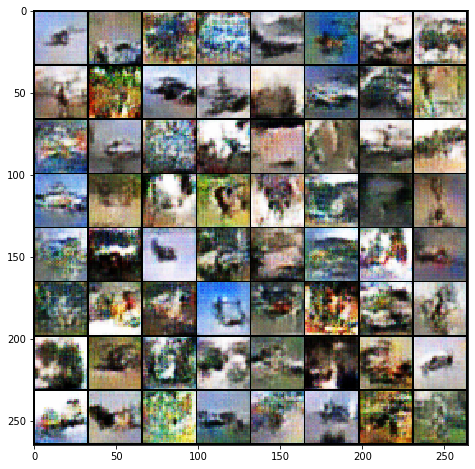

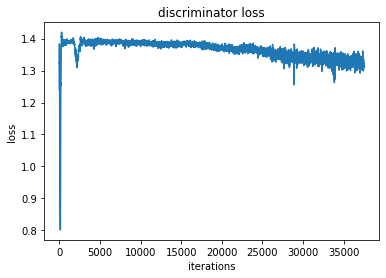

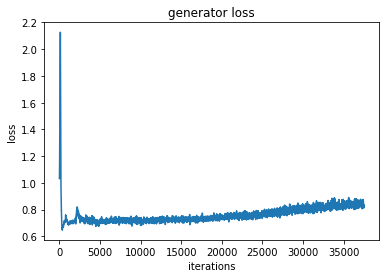

Iteration 37500/39050: dis loss = 1.2752, gen loss = 0.7840
Iteration 37550/39050: dis loss = 1.3929, gen loss = 0.6541
Iteration 37600/39050: dis loss = 1.2199, gen loss = 0.8752
Iteration 37650/39050: dis loss = 1.2655, gen loss = 0.7953
Iteration 37700/39050: dis loss = 1.3954, gen loss = 0.6455
Iteration 37750/39050: dis loss = 1.4066, gen loss = 0.6511
Iteration 37800/39050: dis loss = 1.4227, gen loss = 0.9923
Iteration 37850/39050: dis loss = 1.1798, gen loss = 0.9454
Iteration 37900/39050: dis loss = 1.3106, gen loss = 1.0133
Iteration 37950/39050: dis loss = 1.2211, gen loss = 0.8347
Iteration 38000/39050: dis loss = 1.4920, gen loss = 0.7474
Iteration 38050/39050: dis loss = 1.4514, gen loss = 0.7476
Iteration 38100/39050: dis loss = 1.4630, gen loss = 0.7142
Iteration 38150/39050: dis loss = 1.3116, gen loss = 1.0195
Iteration 38200/39050: dis loss = 1.5137, gen loss = 0.7053
Iteration 38250/39050: dis loss = 1.2573, gen loss = 0.8244
Iteration 38300/39050: dis loss = 1.3438

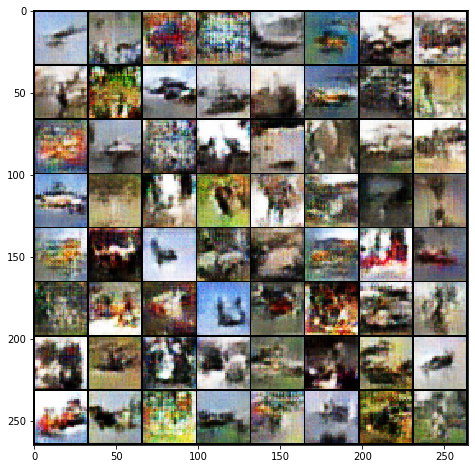

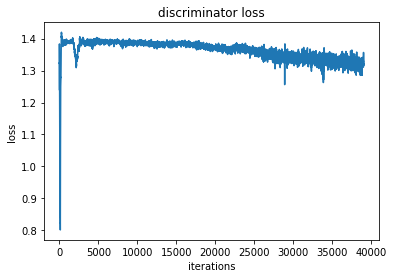

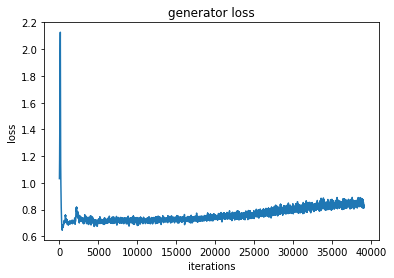

... Done!


In [15]:
tf.reset_default_graph()
set_seed(21)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')

## Problem 2-2: Activation Maximization (10 pts)

GANs notoriously difficult to debug. Here we provide one of methods that are designed for investigating what networks learn, which can be helpful for debugging GANs.

Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to *[Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://arxiv.org/abs/1605.09304)*.

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code.

The batch normalization layers should work in evaluation mode.

We provide the code for this part, as a reference for solving the next part. You may want to go back to the code above and check the following:

*   **Build the computation graph for the loss:** Check the definition of these operations in ```_init_ops()```
    *   ```actmax_sample_op```: generate samples from ```actmax_code```
    *   ```actmax_loss_op```: compute discriminator's loss on samples generated from ```actmax_code```
*   **Define the optimizer:** Check the definition of ```actmax_op```, which updates ```actmax_code```
*   **Feed the data:** Check the function ```actmax_one_sample()```

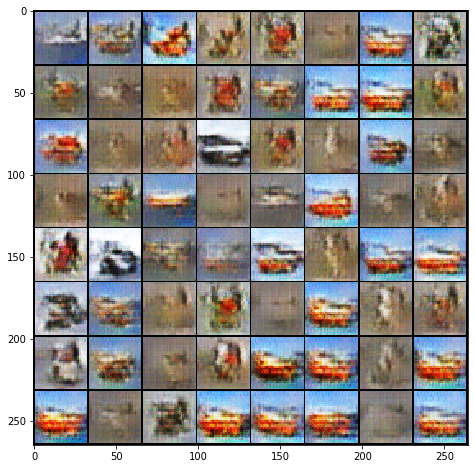

In [18]:
tf.reset_default_graph()
set_seed(241)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

The output should have less variety than those generated from random code. While it is reasonable that the samples that are "most real" makes up only a small portion of the sample space, this also gives us a hint that the so-called "mode collapse", in which the GAN simply fails to model a majority part of the data distribution, is a real problem.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the target image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.

For this part, you need to complete code blocks marked with "Prob 2-2":

*   **Build the computation graph for the loss:** Complete the definition of ```recon_loss_op``` in ```_init_ops()```, which computes the squared L2-distance between ```recon_sample``` and the sample generated from ```actmax_code```.
*   **Define the optimizer:** Modify the definition of ```reconstruct_op``` so that it updates ```actmax_code``` rather than the parameters of the networks.
*   **Feed the data:** Set the proper initial value and feed the proper data in ```reconstruct_one_sample()```

average reconstruction loss = 30.5645


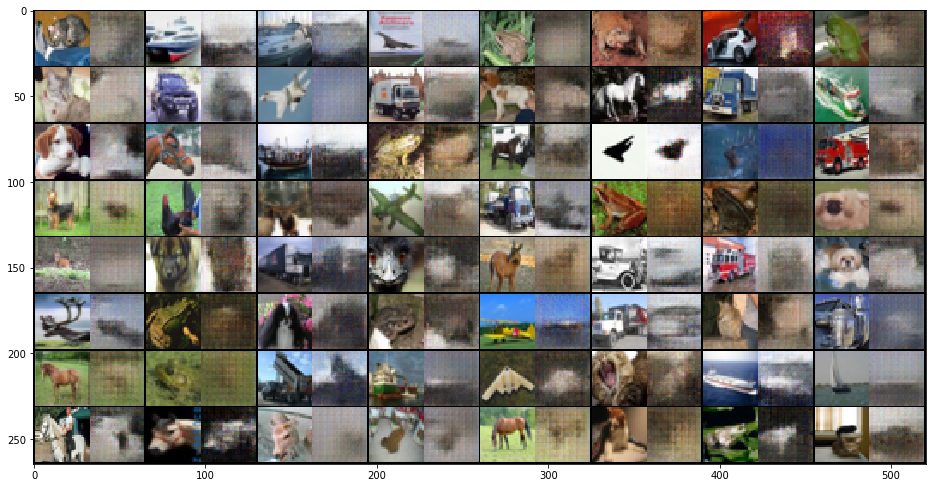

In [19]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (16, 16))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(np.concatenate((test_samples[0:64], reconstructions), axis=2), 1))
        plt.show()

Now you can see the effect of increasing the training epochs. You should be able to achieve a reconstruction loss lower than 32.